# Model Development

## Import packages

In [1]:
import pandas as pd
import numpy as np
import textblob
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, mean_squared_error, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('bmh')
import itertools

## Set files and folders

In [2]:
data_file = r'./Data/features_targets.csv'
data_folder = r'./Data'

## Read data

In [3]:
data = pd.read_csv(data_file, index_col = 0)

C:\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:379: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Features vs labels/targets grouping

In [4]:
dataset_y_class = data.loc[:,['deal_binary']].copy()
dataset_y_continuous = data.loc[:,['deal_probability']].copy()
dataset_x = data.loc[:,data.columns[:-2]].copy()

## Train / test split

In [5]:
X_train,X_test,y_class_train,y_class_test=train_test_split(dataset_x, dataset_y_class, test_size=0.4, random_state=1)
y_continuous_train = dataset_y_continuous.loc[y_class_train.index,:].copy()
y_continuous_test = dataset_y_continuous.loc[y_class_test.index,:].copy()

In [6]:
#Save train/test dataframe index split for benchmark models
train_index = list(X_train.index)
test_index = list(X_test.index)

In [7]:
#Save feature names
feature_labels = list(X_train.columns)

In [8]:
#Convert dataset objects to numpy array
X_train = X_train.values
X_test = X_test.values
y_class_train = y_class_train.values.ravel()
y_class_test = y_class_test.values.ravel()
y_continuous_train = y_continuous_train.values.ravel()
y_continuous_test = y_continuous_test.values.ravel()

## Benchmark models

### Supervised classification benchmark model

The feature dataset has a column named *price_zscore* which will be the basis of the benchmark classifier:

* If the *price_zscore* is equal or above zero, then the item's price is above the category mean and it is predicted that the deal is unlikely to happen.

* If the *price_zscore* is below zero, then the item's price is below the category mean and it is predicted that the deal is likely to happen.

There is no need to setup the training datasets for the classification benchmark because the predictions can be generated without any model fit.

In [9]:
#Buid benchmark feature
dataset_x['class_bench_predictor'] = 1.0
dataset_x.loc[dataset_x.price_zscore>=0,['class_bench_predictor']] = 0.0
#Get predictions and true labels for the classification benchmark
y_predicted_test_class_bench = dataset_x.loc[dataset_x.index.isin(test_index), ['class_bench_predictor']].copy()
y_true_test_class_bench = dataset_y_class.loc[dataset_y_class.index.isin(test_index),:].copy()

In [10]:
#Compute F1-Score in the testing subset
f1_bench_test = f1_score(y_true_test_class_bench.values,y_predicted_test_class_bench.values)

In [11]:
print(f1_bench_test)

0.208259040766


In [12]:
print(classification_report(y_true_test_class_bench.values,y_predicted_test_class_bench.values))

             precision    recall  f1-score   support

        0.0       0.88      0.32      0.46    411497
        1.0       0.12      0.69      0.21     56822

avg / total       0.79      0.36      0.43    468319



### Supervised regression benchmark model

Intuitively, the column *price* should be one of the main drivers of *deal_probability*. Also, it should have a negative relationship with *deal_probability*:

* The higher the *price*, the lower the *deal_probability*.
* The lower the *price*, the higher the *deal_probability*.

In [13]:
#Create train/test datasets for regression benchmark
X_train_reg_bench = dataset_x.loc[dataset_x.index.isin(train_index), ['price']].copy()
X_test_reg_bench = dataset_x.loc[dataset_x.index.isin(test_index), ['price']].copy()
y_train_reg_bench = dataset_y_continuous.loc[dataset_y_continuous.index.isin(train_index),:].copy()
y_true_test_reg_bench = dataset_y_continuous.loc[dataset_y_continuous.index.isin(test_index),:].copy()

In [14]:
#Define a linear regression object
lin_reg = LinearRegression(n_jobs = -1)

In [15]:
#Fit the linear regression model with benchmark data
lin_reg.fit(X_train_reg_bench,y_train_reg_bench)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [16]:
#Generate predictions for the regression benchmark
y_predicted_test_reg_bench = lin_reg.predict(X_test_reg_bench)

In [17]:
#Compute RMSE for the testing subset
rmse_bench_test=np.sqrt(mean_squared_error(y_true = y_true_test_reg_bench.values, y_pred = y_predicted_test_reg_bench))

In [18]:
print(rmse_bench_test)

0.262776358387


## Supervised classification model development

### Initial model comparison with 10-fold cross validation

In [19]:
#Instantiate models with default settings
gnb = GaussianNB()
lr = LogisticRegression(random_state = 1)
lsvc = svm.LinearSVC(random_state = 1)
rfc = RandomForestClassifier(random_state = 1)
gbc = GradientBoostingClassifier(random_state = 1)
abc = AdaBoostClassifier(random_state = 1)
knc = KNeighborsClassifier()

In [20]:
#Set scoring model
scoring_classification = {'f1': make_scorer(f1_score)}

In [21]:
#Cross-validation with 10 folds
cv_gnb=cross_validate(gnb.fit(X_train,y_class_train),X_train,y_class_train,scoring=scoring_classification,cv=10)
cv_lr=cross_validate(lr.fit(X_train,y_class_train),X_train,y_class_train,scoring=scoring_classification,cv=10)
cv_lsvc=cross_validate(lsvc.fit(X_train,y_class_train),X_train,y_class_train,scoring=scoring_classification,cv=10)
cv_rfc=cross_validate(rfc.fit(X_train,y_class_train),X_train,y_class_train,scoring=scoring_classification,cv=10)
cv_gbc=cross_validate(gbc.fit(X_train,y_class_train),X_train,y_class_train,scoring=scoring_classification,cv=10)
cv_abc=cross_validate(abc.fit(X_train,y_class_train),X_train,y_class_train,scoring=scoring_classification,cv=10)
cv_knc=cross_validate(knc.fit(X_train,y_class_train),X_train,y_class_train,scoring=scoring_classification,cv=10)

In [22]:
#Store validation f1 scores across 10 folds
cv_score_gnb = list(cv_gnb['test_f1'])
cv_score_lr = list(cv_lr['test_f1'])
cv_score_lsvc = list(cv_lsvc['test_f1'])
cv_score_rfc = list(cv_rfc['test_f1'])
cv_score_gbc = list(cv_gbc['test_f1'])
cv_score_abc = list(cv_abc['test_f1'])
cv_score_knc = list(cv_knc['test_f1'])

In [23]:
#Create pandas dataframe that aggregates F1-Scores across folds and classification algorithms
cv_score_classifiers = pd.DataFrame({'Benchmark': list([f1_bench_test]*10), 'Gaussian Naive Bayes':cv_score_gnb,'Logistic Regression':cv_score_lr,'Linear SVC':cv_score_lsvc, 'Random Forest Classifier':cv_score_rfc, 'Gradient Boosting Classifier':cv_score_gbc,'AdaBoost Classifier': cv_score_abc, 'KNN Classifier':cv_score_knc})
cv_score_classifiers.index = range(1,11)

In [24]:
cv_score_classifiers

,AdaBoost Classifier,Benchmark,Gaussian Naive Bayes,Gradient Boosting Classifier,KNN Classifier,Linear SVC,Logistic Regression,Random Forest Classifier
1,0.051992,0.208259,0.348505,0.035120,0.149559,0.121898,0.023697,0.140808
2,0.063548,0.208259,0.348281,0.031775,0.157278,0.010036,0.015333,0.148371
3,0.059764,0.208259,0.347017,0.029490,0.150530,0.206037,0.010954,0.149794
4,0.068298,0.208259,0.344090,0.031347,0.153725,0.181827,0.014634,0.141804
5,0.066964,0.208259,0.346889,0.037240,0.153513,0.170667,0.006296,0.147379
6,0.068331,0.208259,0.345524,0.031081,0.147565,0.250901,0.013465,0.133130
7,0.071491,0.208259,0.341215,0.038528,0.158132,0.069607,0.012113,0.137659
8,0.050653,0.208259,0.340559,0.036026,0.148772,0.005974,0.016189,0.148208
9,0.052097,0.208259,0.347760,0.031225,0.149922,0.104537,0.001412,0.135192
10,0.051550,0.208259,0.341712,0.030872,0.150481,0.125679,0.040968,0.132793


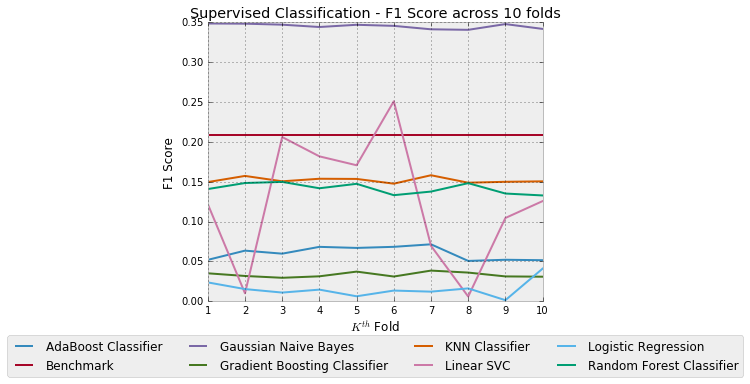

In [85]:
#Plot F1-Score across folds and algorithms
cv_score_classifiers.plot(figsize = (6,5));
plt.title('Supervised Classification - F1 Score across 10 folds')
plt.legend(loc = 9, bbox_to_anchor=(0.5, -0.1), ncol = 4);
plt.ylabel('F1 Score');
plt.xlabel('$K^{th}$ Fold');

In [26]:
#Generate statistics on F1-Score across folds and algorithms
cv_score_classifiers.describe()

,AdaBoost Classifier,Benchmark,Gaussian Naive Bayes,Gradient Boosting Classifier,KNN Classifier,Linear SVC,Logistic Regression,Random Forest Classifier
count,10.000000,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.060469,2.082590e-01,0.345155,0.033270,0.151948,0.124716,0.015506,0.141514
std,0.008264,2.925695e-17,0.003056,0.003151,0.003583,0.080701,0.010732,0.006638
min,0.050653,2.082590e-01,0.340559,0.029490,0.147565,0.005974,0.001412,0.132793
25%,0.052018,2.082590e-01,0.342306,0.031117,0.149649,0.078340,0.011244,0.135809
50%,0.061656,2.082590e-01,0.346206,0.031561,0.150506,0.123789,0.014050,0.141306
75%,0.067964,2.082590e-01,0.347574,0.035799,0.153672,0.179037,0.015975,0.148000
max,0.071491,2.082590e-01,0.348505,0.038528,0.158132,0.250901,0.040968,0.149794


The initial results in the supervised classification problem suggest that a simpler model is more robust. The best model across all 10 folds is the Gaussian Naive Bayes (average F1 score of 0.35 across 10 validation folds).

The Gaussian Naive Bayes does not have hyper-parameters to tune so an optimization of hyper-parameters is not followed here. The reason for not picking other models is because the other models have more degrees of freedom and can add more complexity, resulting in better fits. However, the cross validation analysis was done in order to identify robust models which perform well out-of-sample. This analysis showed that the Gaussian Naive Bayes is the only one to incorporate those characteristics (on a relative basis).


### Supervised classification best model out-of-sample evaluation

In [27]:
#Train Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_train, y_class_train)

GaussianNB(priors=None)

In [28]:
#Create predictions on test dataset
gnb_test_preds = gnb.predict(X_test)

In [29]:
#Evaluate F1 Score in testing dataset
print(f1_score(y_class_test, gnb_test_preds))
print(classification_report(y_class_test, gnb_test_preds))

0.346359643435
             precision    recall  f1-score   support

        0.0       0.92      0.78      0.85    411497
        1.0       0.25      0.54      0.35     56822

avg / total       0.84      0.75      0.79    468319



Note that the F1 Score on the testing dataset maintains the F1 Score level from the cross validation exercise (around the 0.35 level). This is a robust model that is fast and easy to train. Sometimes, complexity does not work, as in this case.

Confusion matrix, without normalization
[[321675  89822]
 [ 26107  30715]]
Normalized confusion matrix
[[ 0.78  0.22]
 [ 0.46  0.54]]


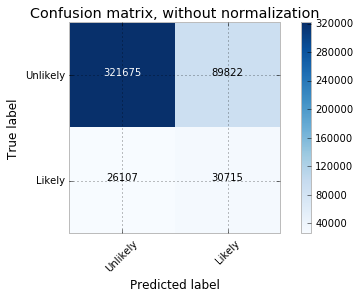

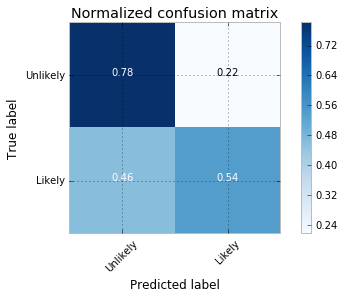

In [30]:
class_names = ['Unlikely','Likely']
#The following function was extracted from the scikit-learn website:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_class_test, gnb_test_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Looking at the confusion matrix, it is clear that  due to the target inbalance (411,497 *Unlikely* deals and 56,822 *Likely* deals), the Gaussian Naive Bayes achieves a higher recall and precision values for *Unlikely* vs. the *Likely* labels.

## Supervised regression model development

### Initial model comparison with 10-fold cross validation

In [31]:
#Instantiate models with default settings
lreg = LinearRegression()
lassoreg = Lasso(random_state = 1)
rr = Ridge(random_state = 1, solver = 'auto')
gbr = GradientBoostingRegressor(random_state = 1, max_features = 10)
mlp = MLPRegressor(random_state = 1, hidden_layer_sizes = (10,10,10), max_iter = 500)

In [32]:
#Set scoring model
scoring_regression = {'mse': make_scorer(mean_squared_error)}

In [33]:
#Cross validation with 10 folds
cv_lreg=cross_validate(lreg.fit(X_train,y_continuous_train),X_train,y_continuous_train,scoring=scoring_regression,cv=10)
cv_lassoreg=cross_validate(lassoreg.fit(X_train,y_continuous_train),X_train,y_continuous_train,scoring=scoring_regression,cv=10)
cv_rr=cross_validate(rr.fit(X_train,y_continuous_train),X_train,y_continuous_train,scoring=scoring_regression,cv=10)
cv_gbr=cross_validate(gbr.fit(X_train,y_continuous_train),X_train,y_continuous_train,scoring=scoring_regression,cv=10)
cv_mlp=cross_validate(mlp.fit(X_train,y_continuous_train),X_train,y_continuous_train,scoring=scoring_regression,cv=10)

In [34]:
#Store validation f1 scores across 10 folds and convert MSE to RMSE
cv_score_lreg = list(cv_lreg['test_mse'])
cv_score_lreg = np.sqrt(cv_score_lreg)
cv_score_lassoreg = list(cv_lassoreg['test_mse'])
cv_score_lassoreg = np.sqrt(cv_score_lassoreg)
cv_score_rr = list(cv_rr['test_mse'])
cv_score_rr = np.sqrt(cv_score_rr)
cv_score_gbr = list(cv_gbr['test_mse'])
cv_score_gbr = np.sqrt(cv_score_gbr)
cv_score_mlp = list(cv_mlp['test_mse'])
cv_score_mlp = np.sqrt(cv_score_mlp)

In [35]:
#Create pandas dataframe with aggregation of RMSE across folds and regression algorithms
cv_score_regressions=pd.DataFrame({'Benchmark':list([rmse_bench_test]*10),'Linear Regression':cv_score_lreg,'Lasso Regression':cv_score_lassoreg,'Ridge Regression':cv_score_rr,'Gradient Boosting Regressor':cv_score_gbr,'Multi-layer Perceptron Regressor':cv_score_mlp})
cv_score_regressions.index = range(1,11)
cv_score_regressions

,Benchmark,Gradient Boosting Regressor,Lasso Regression,Linear Regression,Multi-layer Perceptron Regressor,Ridge Regression
1,0.262776,0.241354,0.257697,0.242828,0.243564,0.242828
2,0.262776,0.242822,0.259277,0.244100,0.246941,0.244100
3,0.262776,0.242922,0.258895,0.244744,0.248249,0.244744
4,0.262776,0.242543,0.258466,0.244044,0.263566,0.244044
5,0.262776,0.242753,0.258544,0.244450,0.246546,0.244450
6,0.262776,0.242964,0.258828,0.244759,0.248780,0.244759
7,0.262776,0.242524,0.258452,0.243906,0.245861,0.243906
8,0.262776,0.241902,0.258088,0.243404,0.245936,0.243404
9,0.262776,0.241520,0.257155,0.243117,0.243765,0.243117
10,0.262776,0.241344,0.256942,0.242784,0.262127,0.242783


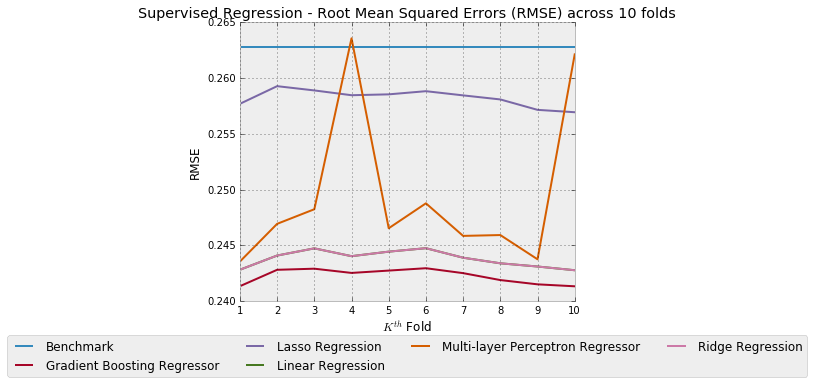

In [86]:
#Plot RMSE across folds and regression algorithms
cv_score_regressions.plot(figsize = (6,5));
plt.title('Supervised Regression - Root Mean Squared Errors (RMSE) across 10 folds')
plt.legend(loc = 9, bbox_to_anchor=(0.5, -0.1), ncol = 4);
plt.ylabel('RMSE');
plt.xlabel('$K^{th}$ Fold');

In [37]:
#Generate RMSE statistics across folds and regression algorithms
cv_score_regressions.describe()

,Benchmark,Gradient Boosting Regressor,Lasso Regression,Linear Regression,Multi-layer Perceptron Regressor,Ridge Regression
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.262776,0.242265,0.258234,0.243813,0.249533,0.243813
std,0.000000,0.000665,0.000761,0.000745,0.007217,0.000745
min,0.262776,0.241344,0.256942,0.242784,0.243564,0.242783
25%,0.262776,0.241616,0.257794,0.243189,0.245880,0.243189
50%,0.262776,0.242533,0.258459,0.243975,0.246743,0.243975
75%,0.262776,0.242805,0.258757,0.244362,0.248647,0.244362
max,0.262776,0.242964,0.259277,0.244759,0.263566,0.244759


### Best regression model tuning

The previous cross validation exercise among 5 regression algorithms - using default hyper-parameters - showed that the lowest RMSE is achieved within the following algorithms:

* Linear Regression
* Gradient Boosting Regressor

From the previous two models, only the Gradient Boosting Regressor allow hyper-parameter tuning. The next stage will tune the hyper-parameters of the Gradient Boosting Regressor algorithm.

In [38]:
#Set tuning parameters
gbr_tuning = [{'learning_rate': [0.1,0.5,1.0]}]

In [39]:
#Set grid search cross validation object
tuned_gbr = GridSearchCV(GradientBoostingRegressor(random_state = 1), gbr_tuning, cv = 10, scoring = 'neg_mean_squared_error')

In [40]:
#Hyper parameter tuning
tuned_gbr.fit(X_train, y_continuous_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'learning_rate': [0.1, 0.5, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [41]:
#Show best parameter from cross validation
tuned_gbr.best_params_

{'learning_rate': 1.0}

In [42]:
print('Average RMSE across folds for the best hyper-parameter:' ,np.sqrt(-tuned_gbr.grid_scores_[2][1]))

Average RMSE across folds for the best hyper-parameter: 0.235012307868


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [43]:
#Generate predictions on test dataset
tuned_gbr_preds = tuned_gbr.predict(X_test)

In [44]:
#Compute RMSE on testing dataset from tuned models
print(np.sqrt(mean_squared_error(y_continuous_test, tuned_gbr_preds)))

0.235926026636


In [45]:
#Re-train a model with default feature to check testing performance and study feature importance
gbr = GradientBoostingRegressor(random_state = 1, max_features = 10)
gbr.fit(X_train, y_continuous_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=10,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=False)

In [46]:
#Check performance in testing subset
gbr_preds = gbr.predict(X_test)
print(np.sqrt(mean_squared_error(y_continuous_test, gbr_preds)))

0.242888895388


In [47]:
#Create a pandas dataframe with feature importance
feature_df = pd.DataFrame(data = gbr.feature_importances_*100, index = feature_labels, columns = ['Importance'])

In [48]:
#Sort dataframe by feature importance (descending)
feature_df.sort_values(by = 'Importance', ascending = False,inplace = True)

In [49]:
#Add a column with cumulative feature importance
feature_df['Importance_Cumulative_Sum'] = feature_df.Importance.cumsum()

In [63]:
#Translate feature labels to English
features_eng = [x[:5] + str(textblob.TextBlob(x).translate(to = 'en')).lower().replace('region','').strip()[5:] if (x.startswith('reg') or x.startswith('cat')) else x for x in feature_labels]
features_translation = dict(zip(feature_labels, features_eng))
feature_df.rename(features_translation, inplace = True)

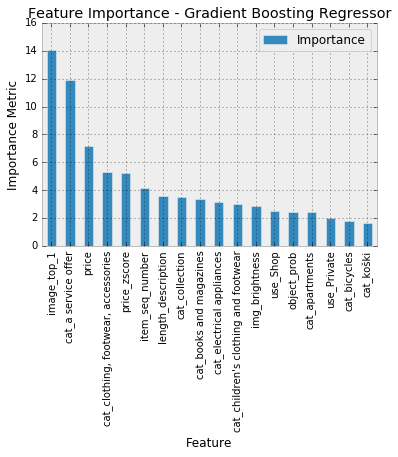

In [84]:
#Plot feature importance
feature_df.loc[feature_df.Importance_Cumulative_Sum<=81,['Importance']].plot(kind = 'bar');
plt.title('Feature Importance - Gradient Boosting Regressor');
plt.xlabel('Feature');
plt.ylabel('Importance Metric');

The plot above shows that 18 features (out of 95) make up about 80% of total feature importance. 
Interesting obsevations:

* Feature importance resembles an exponential distribution, with a small group of features representing most of the overall feature importance.
* The top three features are **_image_top_1_**, **_cat_a service offer_**, and **_price_**, and they represent a third of total feature importance. It is not surprising that a mix of data objects (image, text, and numerical) contribute to the problem's solution.
* Regional information is not significant as it doesn't appear in the most important features.
* Out of the 18 features, four of them were engineered from the original dataset (**_price_zscore_**, **_length_description_**, **_img_brightness_**, and **_object_prob_**). This shows the importance of feature engineering.
* Eight features are associated with the category of the item. It is crucial to get the category of the item well assigned.